In [14]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

# Redéfinir ClusterAdder (doit être identique à celle utilisée lors de l'enregistrement)
class ClusterAdder(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    def fit(self, X, y=None):
        self.kmeans.fit(X)
        return self

    def transform(self, X):
        clusters = self.kmeans.predict(X)
        return np.hstack([X, clusters.reshape(-1, 1)])

# Charger le pipeline
pipeline = joblib.load('Fabien_madelaine_appli.pkl')

# Afficher les étapes du pipeline
print("Étapes du pipeline :", pipeline.named_steps.keys())



Étapes du pipeline : dict_keys(['standardscaler', 'clusteradder', 'votingclassifier'])


In [15]:
def predire_billets(pipeline, nouvelles_donnees, seuil=0.090):
    """
    Prédit si des billets sont vrais ou faux à partir d'un DataFrame.
    Args:
        pipeline: Pipeline chargé.
        nouvelles_donnees: DataFrame avec les colonnes ['length', 'margin_low', 'margin_up', 'height_right'].
        seuil: Seuil de probabilité pour accepter un billet comme vrai (default: 0.90).
    Returns:
        DataFrame: Résultats avec prédictions et probabilités.
    """
    # Extraire les features en conservant les noms de colonnes
    X = nouvelles_donnees[['length', 'height_right', 'margin_up', 'margin_low']]

    # Appliquer chaque étape du pipeline
    X_scaled = pipeline.named_steps['standardscaler'].transform(X)
    X_with_clusters = pipeline.named_steps['clusteradder'].transform(X_scaled)
    proba = pipeline.named_steps['votingclassifier'].predict_proba(X_with_clusters)[:, 1]

    # Ajouter les résultats au DataFrame
    nouvelles_donnees['prediction'] = (proba >= seuil).astype(int)
    nouvelles_donnees['prediction'] = nouvelles_donnees['prediction'].map({0: 'Faux', 1: 'Vrai'})
    nouvelles_donnees['probability'] = proba

    return nouvelles_donnees


In [16]:
DATA_PATH = "data/billets_test.csv"

if not os.path.exists(DATA_PATH):
    print(f"❌ Attention : le fichier '{DATA_PATH}' n'existe pas.")

try:
    nouvelles_donnees = pd.read_csv(DATA_PATH, sep=",")
    print("✅ Données chargées :", nouvelles_donnees.shape)
    display(df.head())
except Exception as e:
    print("❌ Erreur lors du chargement :", e)
    print("⚠️ Tu as bien lu le code avant de l'executer ? 😏")

    

✅ Données chargées : (5, 7)
❌ Erreur lors du chargement : name 'df' is not defined
⚠️ Tu as bien lu le code avant de l'executer ? 😏


In [17]:
nouvelles_donnees = nouvelles_donnees.dropna()

In [18]:
# Afficher les colonnes de votre DataFrame
print("Colonnes dans votre DataFrame :", nouvelles_donnees.columns.tolist())

# Définir les colonnes attendues (doivent correspondre à celles utilisées lors de l'entraînement)
expected_columns = ['length', 'height_right', 'margin_up', 'margin_low']



Colonnes dans votre DataFrame : ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length', 'id']


In [19]:
# Afficher les noms des colonnes attendues par le StandardScaler
print("Noms des colonnes attendues :", pipeline.named_steps['standardscaler'].feature_names_in_)


Noms des colonnes attendues : ['length' 'height_right' 'margin_up' 'margin_low']


In [20]:
# Prédire avec un seuil de 0.90
results = predire_billets(pipeline, nouvelles_donnees, seuil=0.90)
print("\nRésultats des prédictions :")
print(results[['length', 'height_right', 'margin_up', 'margin_low', 'prediction', 'probability']])


Résultats des prédictions :
   length  height_right  margin_up  margin_low prediction  probability
0  113.19        103.73       3.09        4.39       Vrai     0.987558
1  111.82        104.03       3.16        5.27       Faux     0.010898
2  113.39        103.75       3.24        3.81       Vrai     0.996108
3  111.10        103.99       3.30        5.57       Faux     0.000745
4  111.87        104.37       3.07        5.00       Faux     0.017549


In [21]:
# 3. Filtrer les billets prédits comme faux
faux_predits = results[results['prediction'] == 'Faux']
print(f"\nNombre de billets prédits comme faux : {len(faux_predits)}")
print(faux_predits.head())

# 4. Filtrer les billets prédits comme vrais
vrais_predits = results[results['prediction'] == 'Vrai']
print(f"\nNombre de billets prédits comme vrais : {len(vrais_predits)}")
print(vrais_predits.head())


Nombre de billets prédits comme faux : 3
   diagonal  height_left  height_right  margin_low  margin_up  length   id  \
1    171.52       104.17        104.03        5.27       3.16  111.82  B_2   
3    172.02       104.08        103.99        5.57       3.30  111.10  B_4   
4    171.79       104.34        104.37        5.00       3.07  111.87  B_5   

  prediction  probability  
1       Faux     0.010898  
3       Faux     0.000745  
4       Faux     0.017549  

Nombre de billets prédits comme vrais : 2
   diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1   
2    171.78       103.80        103.75        3.81       3.24  113.39  B_3   

  prediction  probability  
0       Vrai     0.987558  
2       Vrai     0.996108  


In [23]:
# Filtrer les faux positifs (faux billets prédits comme vrais)
faux_positifs = results[(results['id'] == 0) & (results['prediction'] == 'Vrai')]

# Afficher la liste complète avec leurs caractéristiques
print("=== Liste des FAUX billets prédits comme VRAIS (faux positifs) ===")
print(f"Nombre : {len(faux_positifs)}")
print(faux_positifs[['length', 'margin_low', 'margin_up', 'height_right', 'probability']].to_string(index=False))

=== Liste des FAUX billets prédits comme VRAIS (faux positifs) ===
Nombre : 0
Empty DataFrame
Columns: [length, margin_low, margin_up, height_right, probability]
Index: []


In [24]:
# Filtrer les faux négatifs (vrais billets prédits comme faux)
vrais_faux = results[(results['id'] == 1) & (results['prediction'] == 'Faux')]

# Afficher la liste complète avec leurs caractéristiques
print("\n=== Liste des VRAIS billets prédits comme FAUX (faux négatifs) ===")
print(f"Nombre : {len(vrais_faux)}")
print(vrais_faux[['length', 'margin_low', 'margin_up', 'height_right', 'probability']].to_string(index=False))


=== Liste des VRAIS billets prédits comme FAUX (faux négatifs) ===
Nombre : 0
Empty DataFrame
Columns: [length, margin_low, margin_up, height_right, probability]
Index: []


In [ ]:
# Définir les features et la cible
features = ['length', 'height_right', 'margin_up', 'margin_low']
X = nouvelles_donnees[features]
y = nouvelles_donnees['is_genuine']

# Diviser les données en train et test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


KeyError: 'id'


=== Résultats des prédictions sur le jeu de test ===
      length  height_right  margin_up  margin_low prediction  probability  \
1043  111.33        103.80       3.27        4.94       Faux     0.008035   
1210  111.53        104.80       3.30        4.86       Faux     0.002487   
61    113.08        104.22       3.00        3.99       Vrai     0.989736   
1262  111.82        104.15       3.40        5.80       Faux     0.001085   
1052  111.79        104.16       3.38        5.45       Faux     0.009092   

      is_genuine  
1043       False  
1210       False  
61          True  
1262       False  
1052       False  

=== Rapport de classification ===
              precision    recall  f1-score   support

        Faux       0.97      1.00      0.99        99
        Vrai       1.00      0.98      0.99       194

    accuracy                           0.99       293
   macro avg       0.99      0.99      0.99       293
weighted avg       0.99      0.99      0.99       293



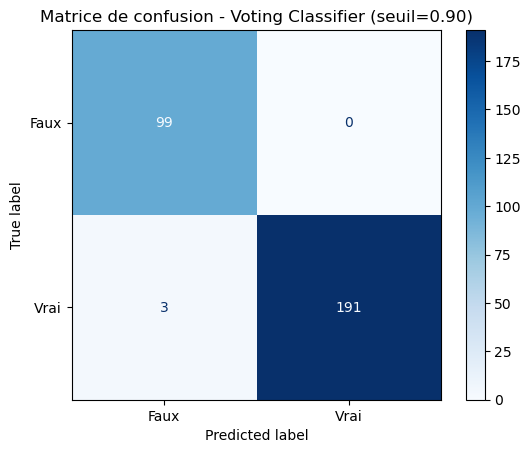

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Appliquer la fonction sur le jeu de test
X_test_with_pred = X_test.copy()
X_test_with_pred = predire_billets(pipeline, X_test_with_pred, seuil=0.90)

# Ajouter la colonne 'is_genuine' pour comparaison
X_test_with_pred['is_genuine'] = y_test.values

# Afficher les résultats
print("\n=== Résultats des prédictions sur le jeu de test ===")
print(X_test_with_pred.head())

# Calculer le rapport de classification
y_pred = X_test_with_pred['prediction'].map({'Faux': 0, 'Vrai': 1})
print("\n=== Rapport de classification ===")
print(classification_report(y_test, y_pred, target_names=['Faux', 'Vrai']))

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Faux', 'Vrai']).plot(cmap='Blues')
plt.title("Matrice de confusion - Voting Classifier (seuil=0.90)")
plt.show()


In [28]:
 #Rapport de classification
print(classification_report(y_test, y_pred, target_names=['Faux', 'Vrai']))

              precision    recall  f1-score   support

        Faux       0.97      1.00      0.99        99
        Vrai       1.00      0.98      0.99       194

    accuracy                           0.99       293
   macro avg       0.99      0.99      0.99       293
weighted avg       0.99      0.99      0.99       293

